# Spectrogram classification 모델 구현

## 1. 데이터 처리와 분류

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)# np.load()함수로 npz파일 열어 배열로 불러온다.

print("홍")

홍


In [2]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [3]:
temp = []
for v in speech_data["label_vals"]: 
    temp.append(label_value[v[0]])
label_data = np.array(temp)
label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [4]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]

print("label : ", speech_data["label_vals"][rand]) 


ipd.Audio(data, rate=sr)

rand num :  8166
label :  ['no']


### Wave를 Spectrogram으로

In [5]:
import librosa
 
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [6]:
tmp = []
for wav in speech_data["wav_vals"] :
    spec = wav2spec(wav)
    tmp.append(spec)

spec_data= np.array(tmp)

print("✅")    
print(speech_data["wav_vals"].shape)
print(spec_data.shape)

✅
(50620, 8000)
(50620, 130, 126)


In [7]:
del speech_data

### 데이터 분리

In [8]:
from sklearn.model_selection import train_test_split

train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)

train_spec = train_spec.reshape(-1, 130, 126, 1)
test_spec = test_spec.reshape(-1, 130, 126, 1)

In [9]:
print(train_spec.shape)
print(test_spec.shape)
print(type(train_spec))

(45558, 130, 126, 1)
(5062, 130, 126, 1)
<class 'numpy.ndarray'>


In [10]:
del spec_data

#### 사용하지 않는 변수 삭제해주는거 잊지말기

In [11]:
import random

print("총 개수:",len(train_spec))

data = train_spec[rand]


print("0 ~ 45557 중  : ", rand) 
print(data.shape)

총 개수: 45558
0 ~ 45557 중  :  8166
(130, 126, 1)


ValueError: too many values to unpack (expected 2)

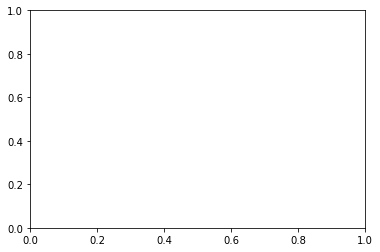

In [13]:
librosa.display.specshow(librosa.amplitude_to_db(data, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

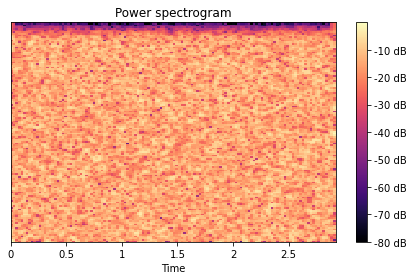

In [14]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

##### 다른분들 것과 비교해보면 뭔가 이상하다.

## 2. 학습을 위한 하이퍼파라미터 설정

In [15]:
batch_size = 32
max_epochs = 10


checkpoint_dir01 = os.getenv('HOME')+'/aiffel/speech_recognition/models/spec'

print(checkpoint_dir01)

/home/aiffel-dj43/aiffel/speech_recognition/models/spec


## 3. data set 구성

### 함수 설정

In [16]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


### tf.data.Dataset

In [17]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126)) #(130,126)

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model01_spec = tf.keras.Model(input_tensor, output_tensor)

model01_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [19]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model01_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir01,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [22]:
history_spec01 = model01_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1419/1423 [============================>.] - ETA: 0s - loss: 1.3886 - accuracy: 0.5246
Epoch 00001: val_loss improved from inf to 0.82867, saving model to /home/aiffel-dj43/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 10s 7ms/step - loss: 1.3870 - accuracy: 0.5252 - val_loss: 0.8287 - val_accuracy: 0.7219
Epoch 2/10
1417/1423 [============================>.] - ETA: 0s - loss: 0.6584 - accuracy: 0.7770
Epoch 00002: val_loss improved from 0.82867 to 0.53871, saving model to /home/aiffel-dj43/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 9s 7ms/step - loss: 0.6579 - accuracy: 0.7772 - val_loss: 0.5387 - val_accuracy: 0.8218
Epoch 3/10
1418/1423 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8503
Epoch 00003: val_loss improved from 0.53871 to 0.43973, saving model to /home/aiffel-dj43/aiffel/speech_recognition/models/spec
1423/1423 [==============================] - 9s 7ms/step - 

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

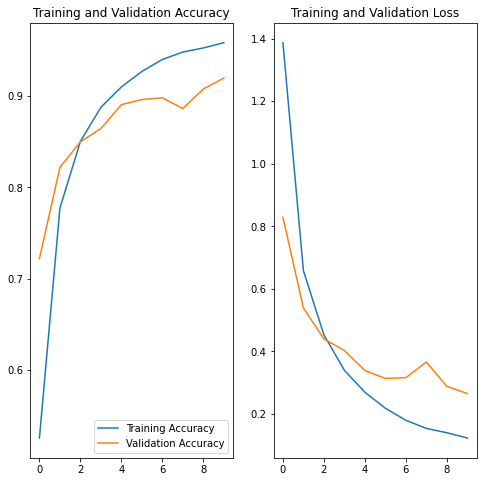

In [23]:
import matplotlib.pyplot as plt

acc = history_spec01.history['accuracy']
val_acc = history_spec01.history['val_accuracy']

loss=history_spec01.history['loss']
val_loss=history_spec01.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.show()

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [24]:
model01_spec.load_weights(checkpoint_dir01)
results = model01_spec.evaluate(test_dataset)

159/159 [==============================] - 20s 127ms/step - loss: 0.2660 - accuracy: 0.9196


In [25]:
print("loss value: {:.3f}".format(results[0]))

loss value: 0.266


In [26]:
print("accuracy value: {:.4f}%".format(results[1]*100))

accuracy value: 91.9597%


#### 위에서 그림을 그려봤을때 다른 분들의 결과와 많이 달라보여서 걱정했는데 결과값은 그럭저럭 비슷하게 나온 것 같다.  

#### 아무것도 모르는 상태에서 Aiffel을 시작했다. 한 달 정도 지난 시점인데 눈치만 늘어난 것 같다. 뭔가 원리를 이해하고 싶은데 지금은 보고 따라하는 것만해도 벅찬 상태다. 조금더 시간이 흐른후 다시 보면서 좀더 이해를 해보고싶다.